# Introduction

In this notebook we build a convolutional neural network (CNN), using TensorFlow and Keras, to detect metastatic cancer based on images from the PatchCamelyon (PCam) image dataset. We experiment with three model architectures, moving from a simple model to a more deep, complex one. The third model yielded a public score of 92.78% in classification of the test data.

The notebook progresses in the following manner: Preliminaries and set up; Data exploration, sampling; Model architecture, plan; Model training; Analysis and conclusion.

HitHub location: https://github.com/beha9089/DTSA5511_CNN

# Preliminaries and Setup

This notebook mostly uses TensorFlow/Keras modules, so we import TensorFlow and Keras, as well as the layers module. Additionally, we import the train/test split function from scikit-learn, and the Keras ImageDataGenerator class, which we will use to create our TF dataset.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The training and test data for this challenge are located within the input folder, and two CSVs are provided that contain the file names for each dataset. Below we read in these two CSVs to define a DataFrame for each set, containing the id (file name), label (training data only), and file path. Additionally, we define the path variable, which will be used throughout the notebook to more efficiently make references to the input folder.

In [2]:
# Define the base file path
path = '/kaggle/input/histopathologic-cancer-detection/'

# Load the sample submission and the training data into DataFrames
train_labels = pd.read_csv(path + 'train_labels.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

# Create a DF for the test images, same style as the train_labels
test_labels = pd.DataFrame(sample_submission.id)

# Add the image file paths in the DataFrames
train_labels['file_path'] = path + 'train/' + train_labels['id'] + '.tif'
test_labels['file_path'] = path + 'test/' + test_labels['id'] + '.tif'

# Check on the data load
print(f'train_labels shape = {train_labels.shape}')
print(f'test_labels shape = {test_labels.shape}')


train_labels shape = (220025, 3)
test_labels shape = (57458, 2)


# Data Exploration

Each image in the PCam dataset has a shape of 96-96-3; that is, 96 pixels square with 3 pixels giving the image color (RGB). Each image in the training set additionally is provided with a binary (0/1) value to indicator the presence of cancer.

The training and test sets contain 220,025 and 57,458 images, respectively. The output below shows that the training data are fairly well balanced between the positive (1) and negative (0) cases, at an approxiamte 40/60 split. Thus we consider sampling or other adjustments to balance the training data to be unneccessary. However, due to the large number of training examples, we will sample from within the available data to define our training data and not utilize the entire set.

In [3]:
print('Total count of labels, number of positive labels, and percentage of labels that are positive:')
train_labels['label'].agg(['count', 'sum', 'mean'])

Total count of labels, number of positive labels, and percentage of labels that are positive:


count    220025.000000
sum       89117.000000
mean          0.405031
Name: label, dtype: float64

Each image is a 3D array of shape 96-96-3:

In [5]:
print(f"Image shape: {plt.imread(train_labels.loc[0, 'file_path']).shape}")

Image shape: (96, 96, 3)


Let's view a few images, to get a sample of what it is we will be learning.

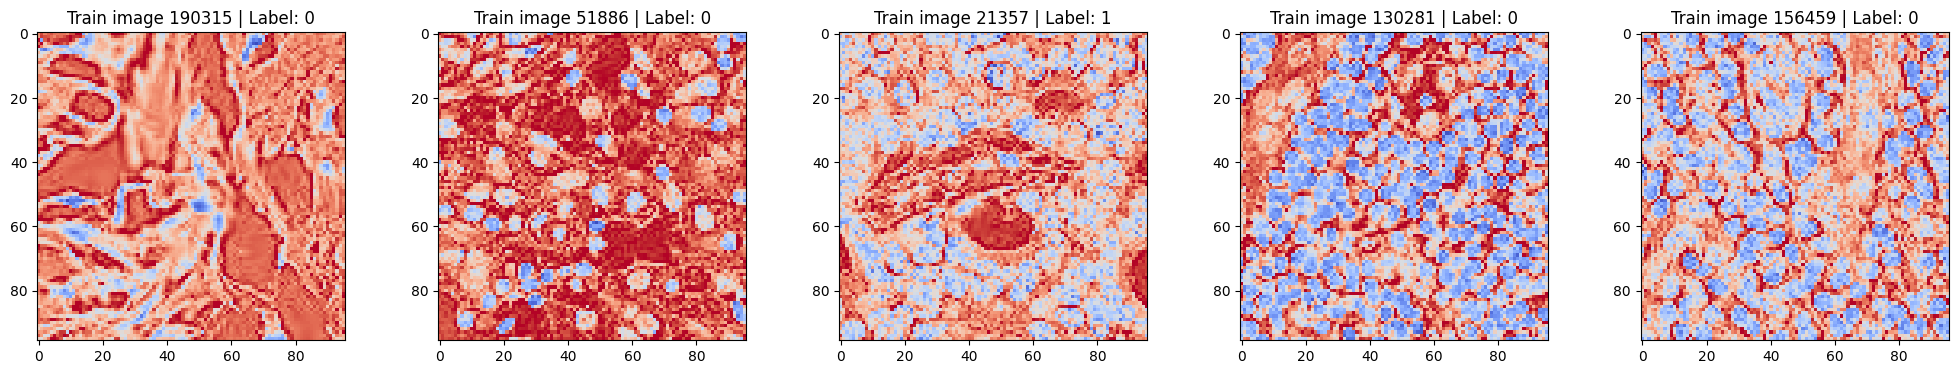

In [6]:
fig = plt.figure(figsize=(25, 4))
img_sample = 5
plt_indx = 1

for indx in train_labels.sample(n = img_sample).index:
    ax = fig.add_subplot(1, img_sample, plt_indx)
    img = plt.imread(train_labels.loc[indx, 'file_path'])
    plt.imshow(img[:, :, 0], cmap = plt.cm.coolwarm)
    ax.set_title(f'Train image {indx} | Label: {train_labels.loc[indx, "label"]}')
    plt_indx += 1

### Sampling and Data Setup

As mentioned above, there are more training images than we can effectively use, so instead of taking the entire training set into the models, we will randomly sample from the positive and negative classes. For testing and exploration we sampled 10,000 images from each class, which allowed for faster model training and thus architecture exploration. For the final training run and submission to the leaderboard we sampled 30,000 images from each class.

Below we define the samples based on index into the train_labels DataFrame. we then use these indices to sample records from the DataFrame, storing the sampled images, split into train and validation sets, in the working directory. After the sample images are loaded to the working directory, we define a data generator and then finally the train and validation datasets.

In [3]:
sample_size = 30*1000
train_samples_0 = train_labels.loc[train_labels.label == 0].sample(n = sample_size).index
train_samples_1 = train_labels.loc[train_labels.label == 1].sample(n = sample_size).index
train_samples = train_samples_0.union(train_samples_1)

In [4]:
# Create the main sub-directory
base_path = path + 'train/'
base_dir = 'base_dir'
os.mkdir(base_dir)

# Create directories for training and validation data
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(train_dir)
os.mkdir(val_dir)

# Complete the train and validation directories with positive/negative folders
os.mkdir(os.path.join(train_dir, '0'))
os.mkdir(os.path.join(train_dir, '1'))
os.mkdir(os.path.join(val_dir, '0'))
os.mkdir(os.path.join(val_dir, '1'))

# Define train and validation data based on the previously defined samples
X_train, X_val = train_test_split(train_labels.loc[train_samples], test_size = 0.2)

# Load the training images
for indx in X_train.index:
    img_label = str(X_train.loc[indx, 'label'])
    img_name = X_train.loc[indx, 'id'] + '.tif'
    img_dest = os.path.join(train_dir, img_label, img_name)
    shutil.copyfile(X_train.loc[indx, 'file_path'], img_dest)
print('Train directory loaded')

# Load the validation images
for indx in X_val.index:
    img_label = str(X_val.loc[indx, 'label'])
    img_name = X_val.loc[indx, 'id'] + '.tif'
    img_dest = os.path.join(val_dir, img_label, img_name)
    shutil.copyfile(X_val.loc[indx, 'file_path'], img_dest)
print('Validation directory loaded')

# Confirm the directories are loaded by counting the files in each
print(len(os.listdir('base_dir/train_dir/0')))
print(len(os.listdir('base_dir/train_dir/1')))
print(len(os.listdir('base_dir/val_dir/0')))
print(len(os.listdir('base_dir/val_dir/1')))

Train directory loaded
Validation directory loaded
23925
24075
6075
5925


Below we complete the preparation/loading of the data for model training and evaluation. To complete this we use an ImageDataGenerator, which performs data preprocessing and batching, with the function flow_from_directory. Here we specify the batch size to be 32, carry forward the same 20% validation split, rescale the pixel values to the range [0, 1], and enable random flips and rotations.

It is of note that ImageDataGenerator is deprecated by TensorFlow and it is recommended that it not be used in new code. Alternative approaches were trialed but these were unsuccessful as they do not support TIFF images. we suspect the use of this generator has resulted in the less-than-ideal performance in training, as it does not support caching and pre-fetching. Additional time is needed to further investigat alternative data loading options to improve efficiency. 
An additional aside, we initially utilized the function flow_from_dataframe, as we already had the training data in a DataFrame, but this seemed slow during training. This motivated the move to establishing a sub-directory for the data.

In [5]:
batch_size = 32
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2, rotation_range = 20, horizontal_flip = True,  vertical_flip = True)

X_train = img_gen.flow_from_directory(train_dir, target_size = (96, 96), class_mode = 'binary', shuffle = True, batch_size = batch_size)
X_val = img_gen.flow_from_directory(val_dir, target_size = (96, 96), class_mode = 'binary', shuffle = True, batch_size = batch_size)

Found 48000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


# Architecture and Plan

Our approach is to train three CNNs on the training and validation datasets established above and submit the results from the best performing model, based on validation results. We chose a simple base architecture and somewhat expand on this over the course of the additional two models. The simple model was made initially as a quick experimentation and first pass, but it demonstrated good performance.

The three models move from simplest to more complex, although the third is still relatively small (by depth, number of parameters). Each model utilizes a binary cross entropy loss and an Adam optimizer in conjunction with an exponential decay learning rate schedule. Additionally, an early stop callback was added to monitor validation loss during training (though this appears to have not activated . . .).

1. The first model consists of two convolution/pooling layers with ReLU activations, with 32 and 64 filters respectively, a dropout of 0.5, and a final dense layer with sigmoid activation.
2. The second model is identical to the first except for the addition of a third convolution/pooling layer, with 128 filters and ReLU activation, prior to dropout.
3. The third model similarly extends model 2 with the addition of a fourth convolution/pooling layer, with 256 filters and ReLU activation, prior to dropout. Additionally, the dropout rate is reduced from 0.5 to 0.3. 

# Model Training

Define the EarlyStopping callback and learning rate schedule. The callback is set up to monitor the validation loss during training and end model training after 5 epochs without improvement to this loss. The learning rate schedule decays the learning rate from an initial rate of 0.001 every 100,000 steps.

In [12]:
earl_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, min_delta = 0.001, mode = 'min')
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.001, decay_steps = 100000, decay_rate = 0.96, staircase = True)

### Model 1

In [13]:
opt_adam = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

model1 = keras.Sequential([
    keras.Input(shape = (96, 96, 3)),
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid'),
    ]
)
model1.compile(loss = 'binary_crossentropy', optimizer = opt_adam, metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 30976)             0         
                                                                 
 dropout (Dropout)           (None, 30976)             0

Epoch 1/25
1500/1500 [==============================] - 236s 156ms/step - loss: 0.4996 - accuracy: 0.7635 - auc: 0.8378 - val_loss: 0.4834 - val_accuracy: 0.7711 - val_auc: 0.8769
Epoch 2/25
1500/1500 [==============================] - 233s 156ms/step - loss: 0.4502 - accuracy: 0.7943 - auc: 0.8711 - val_loss: 0.4094 - val_accuracy: 0.8217 - val_auc: 0.9004
Epoch 3/25
1500/1500 [==============================] - 234s 156ms/step - loss: 0.4227 - accuracy: 0.8115 - auc: 0.8880 - val_loss: 0.3825 - val_accuracy: 0.8288 - val_auc: 0.9101
Epoch 4/25
1500/1500 [==============================] - 235s 157ms/step - loss: 0.4108 - accuracy: 0.8195 - auc: 0.8952 - val_loss: 0.3681 - val_accuracy: 0.8396 - val_auc: 0.9177
Epoch 5/25
1500/1500 [==============================] - 231s 154ms/step - loss: 0.4019 - accuracy: 0.8251 - auc: 0.8999 - val_loss: 0.3771 - val_accuracy: 0.8384 - val_auc: 0.9196
Epoch 6/25
1500/1500 [==============================] - 236s 157ms/step - loss: 0.3970 - accuracy: 0

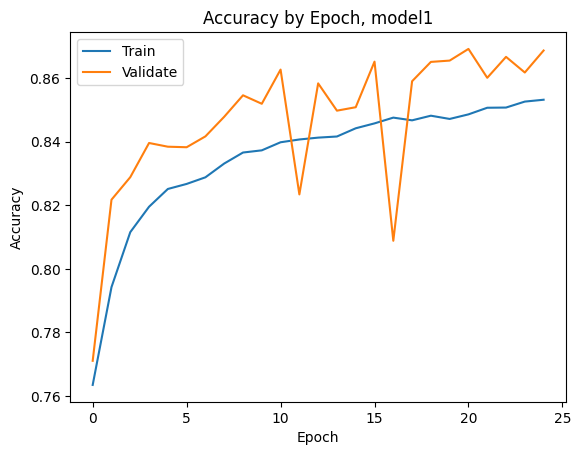

In [14]:
mod1_hist = model1.fit(X_train, validation_data = X_val, epochs = 25, callbacks = [earl_stop], verbose = 2)

plt.plot(mod1_hist.history['accuracy'])
plt.plot(mod1_hist.history['val_accuracy'])
plt.title('Accuracy by Epoch, model1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc = 'upper left')
plt.show()

### Model 2

In [15]:
opt_adam = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

model2 = keras.Sequential([
    keras.Input(shape = (96, 96, 3)),
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid'),
    ]
)
model2.compile(loss = 'binary_crossentropy', optimizer = opt_adam, metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 128)     

Epoch 1/25
1500/1500 [==============================] - 247s 163ms/step - loss: 0.4920 - accuracy: 0.7648 - auc: 0.8426 - val_loss: 0.4336 - val_accuracy: 0.8055 - val_auc: 0.8829
Epoch 2/25
1500/1500 [==============================] - 242s 161ms/step - loss: 0.4430 - accuracy: 0.7986 - auc: 0.8761 - val_loss: 0.3932 - val_accuracy: 0.8263 - val_auc: 0.9044
Epoch 3/25
1500/1500 [==============================] - 245s 163ms/step - loss: 0.4160 - accuracy: 0.8152 - auc: 0.8926 - val_loss: 0.3977 - val_accuracy: 0.8213 - val_auc: 0.9160
Epoch 4/25
1500/1500 [==============================] - 243s 162ms/step - loss: 0.3953 - accuracy: 0.8255 - auc: 0.9044 - val_loss: 0.3896 - val_accuracy: 0.8204 - val_auc: 0.9264
Epoch 5/25
1500/1500 [==============================] - 243s 162ms/step - loss: 0.3818 - accuracy: 0.8333 - auc: 0.9114 - val_loss: 0.3609 - val_accuracy: 0.8401 - val_auc: 0.9274
Epoch 6/25
1500/1500 [==============================] - 244s 163ms/step - loss: 0.3698 - accuracy: 0

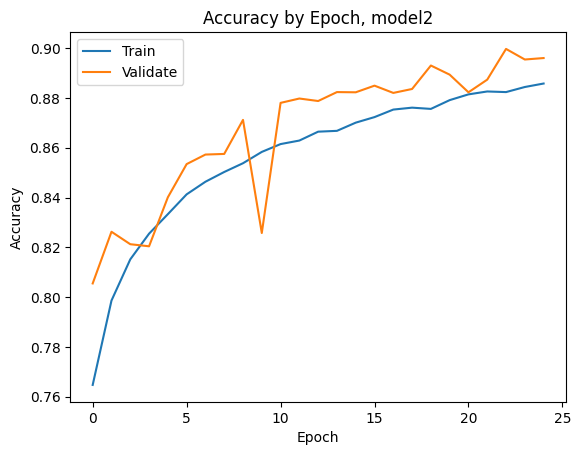

In [16]:
mod2_hist = model2.fit(X_train, validation_data = X_val, epochs = 25, callbacks = [earl_stop], verbose = 2)

plt.plot(mod2_hist.history['accuracy'])
plt.plot(mod2_hist.history['val_accuracy'])
plt.title('Accuracy by Epoch, model2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc = 'upper left')
plt.show()

### Model 3

In [17]:
opt_adam = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

model3 = keras.Sequential([
    keras.Input(shape = (96, 96, 3)),
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Conv2D(256, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'sigmoid'),
    ]
)
model3.compile(loss = 'binary_crossentropy', optimizer = opt_adam, metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 128)     

Epoch 1/25
1500/1500 [==============================] - 236s 155ms/step - loss: 0.5027 - accuracy: 0.7570 - auc: 0.8350 - val_loss: 0.4215 - val_accuracy: 0.8111 - val_auc: 0.8912
Epoch 2/25
1500/1500 [==============================] - 233s 155ms/step - loss: 0.4316 - accuracy: 0.8043 - auc: 0.8830 - val_loss: 0.3833 - val_accuracy: 0.8311 - val_auc: 0.9114
Epoch 3/25
1500/1500 [==============================] - 234s 156ms/step - loss: 0.3979 - accuracy: 0.8243 - auc: 0.9019 - val_loss: 0.3441 - val_accuracy: 0.8510 - val_auc: 0.9278
Epoch 4/25
1500/1500 [==============================] - 233s 155ms/step - loss: 0.3686 - accuracy: 0.8379 - auc: 0.9166 - val_loss: 0.3387 - val_accuracy: 0.8570 - val_auc: 0.9336
Epoch 5/25
1500/1500 [==============================] - 234s 156ms/step - loss: 0.3543 - accuracy: 0.8465 - auc: 0.9232 - val_loss: 0.3227 - val_accuracy: 0.8658 - val_auc: 0.9378
Epoch 6/25
1500/1500 [==============================] - 240s 160ms/step - loss: 0.3377 - accuracy: 0

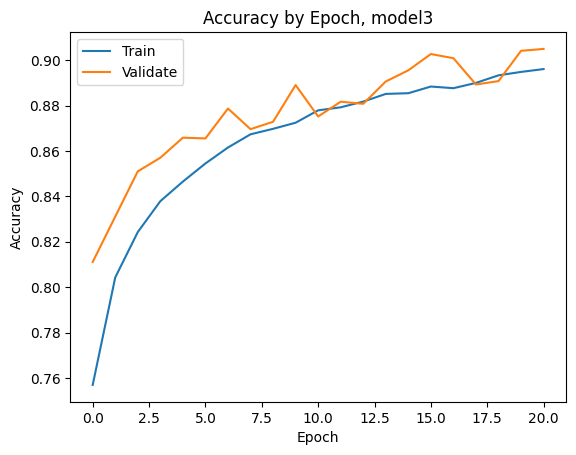

In [18]:
mod3_hist = model3.fit(X_train, validation_data = X_val, epochs = 25, callbacks = [earl_stop], verbose = 2)

plt.plot(mod3_hist.history['accuracy'])
plt.plot(mod3_hist.history['val_accuracy'])
plt.title('Accuracy by Epoch, model3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc = 'upper left')
plt.show()

In [ ]:
results = model1.evaluate(X_val, verbose = 0)
print(f'model1 validation loss and accuracy: {round(results[0], 4)}, {round(results[1], 4)}')
results = model2.evaluate(X_val, verbose = 0)
print(f'model2 validation loss and accuracy: {round(results[0], 4)}, {round(results[1], 4)}')
results = model3.evaluate(X_val, verbose = 0)
print(f'model3 validation loss and accuracy: {round(results[0], 4)}, {round(results[1], 4)}')

# Analysis and Conclusion

These relatively simple CNNs performed well at the task of classifying images in the PCam dataset as cancerous/non-cancerous. The final and most complicated model built consisted of just four convolution layers and 392,513 learnable parameters and earned a 92.78% classification score on the test data. Additionally, this model was trained on 60,000 randomly sampled images from the total 220,025 images available for training.

Given more time and resources, I would like to experiment with deeper models and different configurations of layers. The results in this notebook show that the first two models were underpowered for the problem, and additional layers and parameters learned the data more effectively. For example, no models contained dense layers, except for the output layer, and I would like to understand the impact of the addition of a fully connected layer. Further, I would like to attempt additional regularization techniques and experiment with alternative pooling and dropout configurations. 

Although I would like to experiment with various configurations and architectures, my first concern with these models is the inefficiency of training. Training was significantly slower than expected, often taking 150-160 ms per step. Further, GPU utilization was low. I suspect that these issues have the same cause and are a result of a bottleneck due to the use of the deprecated data generator ImageDataGenerator, which does not support caching or pre-fetching. 

## Submission

In [19]:
test_gen = img_gen.flow_from_dataframe(test_labels, x_col = 'file_path', y_col = None, target_size = (96, 96), batch_size = batch_size, class_mode = None, validate_filenames = False, shuffle = False)

Found 57458 non-validated image filenames.


In [22]:
#model1.predict(test_gen)
#model2.predict(test_gen)
preds3 = model3.predict(test_gen)

1796/1796 [==============================] - 694s 386ms/step


In [28]:
test_labels['label'] = preds3
submission = test_labels[['id', 'label']].set_index('id')

submission.to_csv('preds3.csv') 

In [20]:
model1.save('model1.keras')
model2.save('model2.keras')
model3.save('model3.keras')